C:\Users\arnas\AppData\Local\Temp\ipykernel_4904\204565692.py:18: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_final['Date'] = pd.to_datetime(df_final['Date'], dayfirst=True)


Initiating Advanced Training for 'Draw-Finder' with Temporal Rank Feature...
Generating temporal league rank for the entire dataset...


100%|██████████| 9232/9232 [00:00<00:00, 25977.23it/s]


Temporal Rank feature created successfully.

Training new Draw-Finder model with advanced features...


c:\Users\arnas\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:10:24] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Model Evaluation on Test Set ---

Classification Report:
              precision    recall  f1-score   support

Not-Draw (0)       0.76      0.94      0.84      1394
    Draw (1)       0.32      0.09      0.14       453

    accuracy                           0.73      1847
   macro avg       0.54      0.51      0.49      1847
weighted avg       0.65      0.73      0.67      1847


Confusion Matrix:
[[1305   89]
 [ 412   41]]


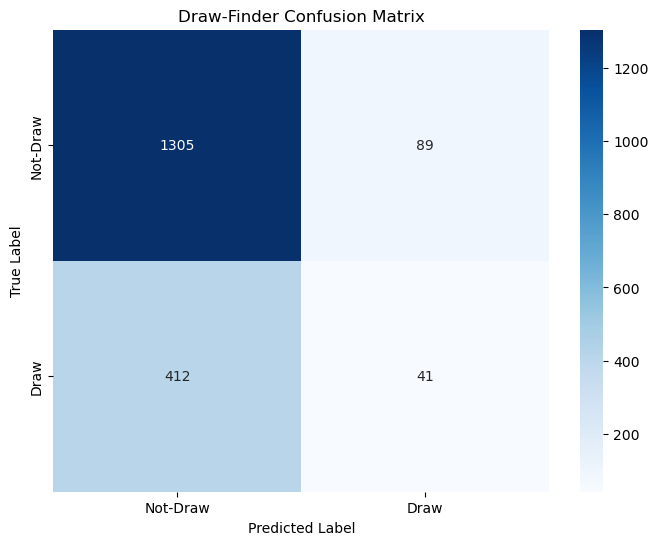


Advanced 'Draw-Finder' model and encoders have been saved successfully!


In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import pickle
from collections import defaultdict
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Initiating Advanced Training for 'Draw-Finder' with Temporal Rank Feature...")

# --- 1. Load Data ---
df_final = pd.read_csv("full_feature_dataset_expanded.csv")
df_final['Date'] = pd.to_datetime(df_final['Date'], dayfirst=True)
df_final = df_final.sort_values('Date') # Crucial for temporal calculations

# --- 2. Advanced Feature Engineering: Create Temporal League Rank ---
print("Generating temporal league rank for the entire dataset...")
def get_season(date):
    if date.month >= 8:
        return f"{date.year}-{date.year + 1}"
    else:
        return f"{date.year - 1}-{date.year}"

df_final['Season'] = df_final['Date'].apply(get_season)

ranks_home = []
ranks_away = []
points_cache = defaultdict(lambda: defaultdict(int)) # Cache points per season

for index, row in tqdm(df_final.iterrows(), total=df_final.shape[0]):
    current_date = row['Date']
    current_season = row['Season']
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    
    # Get current standings from cache
    season_points = points_cache[current_season]
    
    # Convert to a sorted list of tuples (team, points)
    standings = sorted(season_points.items(), key=lambda item: item[1], reverse=True)
    rank_map = {team: rank + 1 for rank, (team, points) in enumerate(standings)}
    
    # Get rank BEFORE this match is played
    ranks_home.append(rank_map.get(home_team, 20)) # Default to 20th if not found
    ranks_away.append(rank_map.get(away_team, 20))
    
    # Update points in cache AFTER getting ranks
    if row['FTR'] == 'H':
        points_cache[current_season][home_team] += 3
    elif row['FTR'] == 'A':
        points_cache[current_season][away_team] += 3
    elif row['FTR'] == 'D':
        points_cache[current_season][home_team] += 1
        points_cache[current_season][away_team] += 1

df_final['HomeTeam_League_Rank'] = ranks_home
df_final['AwayTeam_League_Rank'] = ranks_away
print("Temporal Rank feature created successfully.")

# --- 3. Prepare Data for Model ---
df_final['is_draw'] = np.where(df_final['FTR'] == 'D', 1, 0)

form_feature_names = [col for col in df_final.columns if 'form' in col]
h2h_feature_names = [col for col in df_final.columns if 'H2H' in col]
odds_feature_names = [col for col in df_final.columns if 'Avg_Odds' in col]
# ADD THE NEW FEATURES TO THE LIST
final_feature_list = ['HomeTeam', 'AwayTeam'] + odds_feature_names + form_feature_names + h2h_feature_names + ['HomeTeam_League_Rank', 'AwayTeam_League_Rank']

X = df_final[final_feature_list].copy()
y = df_final['is_draw']

home_team_encoder_d = LabelEncoder()
away_team_encoder_d = LabelEncoder()
X['HomeTeam'] = home_team_encoder_d.fit_transform(X['HomeTeam'])
X['AwayTeam'] = away_team_encoder_d.fit_transform(X['AwayTeam'])

draw_encoders = {
    'home_team': home_team_encoder_d,
    'away_team': away_team_encoder_d
}
with open('draw_encoders.pkl', 'wb') as file:
    pickle.dump(draw_encoders, file)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 4. Apply SMOTE ---
sm = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# --- 5. Train Model ---
print("\nTraining new Draw-Finder model with advanced features...")
scale_pos_weight = np.sum(y_train_res == 0) / np.sum(y_train_res == 1)
draw_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42, scale_pos_weight=scale_pos_weight, use_label_encoder=False)
draw_model.fit(X_train_res, y_train_res)

print("\n--- Model Evaluation on Test Set ---")
y_pred = draw_model.predict(X_test)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not-Draw (0)', 'Draw (1)']))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not-Draw', 'Draw'], yticklabels=['Not-Draw', 'Draw'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Draw-Finder Confusion Matrix')
plt.show()


# --- 6. Save Model ---
with open('draw_model.pkl', 'wb') as file:
    pickle.dump(draw_model, file)

print("\nAdvanced 'Draw-Finder' model and encoders have been saved successfully!")



C:\Users\arnas\AppData\Local\Temp\ipykernel_4904\2921759375.py:17: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_final['Date'] = pd.to_datetime(df_final['Date'], dayfirst=True)


Initiating Advanced Training for 'Winner-Picker' with Temporal Rank Feature...
Generating temporal league rank for the entire dataset...


100%|██████████| 9232/9232 [00:00<00:00, 26106.52it/s]
c:\Users\arnas\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:09:25] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Temporal Rank feature created successfully.

Training new Winner-Picker model with advanced features...
Model training complete.

--- Model Evaluation on Test Set ---

Classification Report:
              precision    recall  f1-score   support

           A       0.66      0.58      0.61       549
           H       0.75      0.81      0.77       845

    accuracy                           0.72      1394
   macro avg       0.70      0.69      0.69      1394
weighted avg       0.71      0.72      0.71      1394


Confusion Matrix:
[[316 233]
 [164 681]]


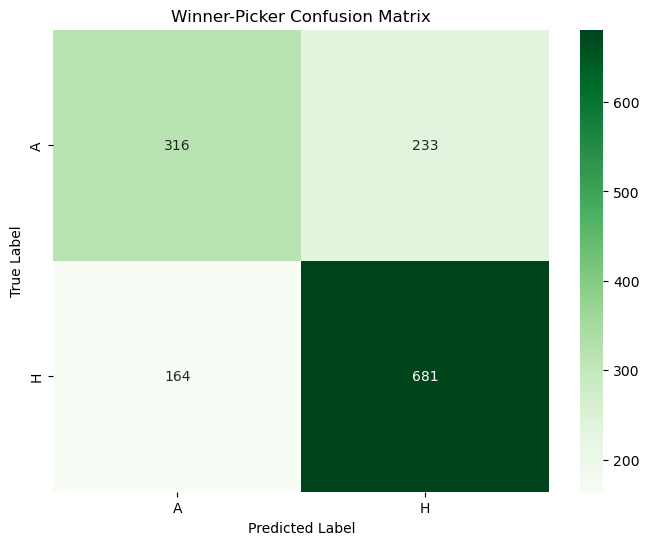


Saving the trained model and encoders...

Advanced 'Winner-Picker' model and encoders have been saved successfully!


In [6]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
from collections import defaultdict
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Initiating Advanced Training for 'Winner-Picker' with Temporal Rank Feature...")

# --- 1. Load Data ---
df_final = pd.read_csv("full_feature_dataset_expanded.csv")
df_final['Date'] = pd.to_datetime(df_final['Date'], dayfirst=True)
df_final = df_final.sort_values('Date')

# --- 2. Advanced Feature Engineering: Create Temporal League Rank ---
print("Generating temporal league rank for the entire dataset...")
def get_season(date):
    if date.month >= 8:
        return f"{date.year}-{date.year + 1}"
    else:
        return f"{date.year - 1}-{date.year}"

df_final['Season'] = df_final['Date'].apply(get_season)

ranks_home = []
ranks_away = []
points_cache = defaultdict(lambda: defaultdict(int))

for index, row in tqdm(df_final.iterrows(), total=df_final.shape[0]):
    current_date = row['Date']
    current_season = row['Season']
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    
    season_points = points_cache[current_season]
    standings = sorted(season_points.items(), key=lambda item: item[1], reverse=True)
    rank_map = {team: rank + 1 for rank, (team, points) in enumerate(standings)}
    
    ranks_home.append(rank_map.get(home_team, 20))
    ranks_away.append(rank_map.get(away_team, 20))
    
    if row['FTR'] == 'H':
        points_cache[current_season][home_team] += 3
    elif row['FTR'] == 'A':
        points_cache[current_season][away_team] += 3
    elif row['FTR'] == 'D':
        points_cache[current_season][home_team] += 1
        points_cache[current_season][away_team] += 1

df_final['HomeTeam_League_Rank'] = ranks_home
df_final['AwayTeam_League_Rank'] = ranks_away
print("Temporal Rank feature created successfully.")

# --- 3. Prepare Data for Model ---
form_feature_names = [col for col in df_final.columns if 'form' in col]
h2h_feature_names = [col for col in df_final.columns if 'H2H' in col]
odds_feature_names = [col for col in df_final.columns if 'Avg_Odds' in col]
final_feature_list = ['HomeTeam', 'AwayTeam'] + odds_feature_names + form_feature_names + h2h_feature_names + ['HomeTeam_League_Rank', 'AwayTeam_League_Rank']

non_draw_df = df_final[df_final['FTR'] != 'D'].copy()
X = non_draw_df[final_feature_list].copy()
y = non_draw_df['FTR']

# --- 4. Encode Features and Target ---
home_team_encoder_wl = LabelEncoder()
away_team_encoder_wl = LabelEncoder()
y_encoder_wl = LabelEncoder()

X['HomeTeam'] = home_team_encoder_wl.fit_transform(X['HomeTeam'])
X['AwayTeam'] = away_team_encoder_wl.fit_transform(X['AwayTeam'])
y_encoded = y_encoder_wl.fit_transform(y)

# --- 5. Split Data into Training and Test Sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# --- 6. Train Model ---
print("\nTraining new Winner-Picker model with advanced features...")
winner_picker_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42, use_label_encoder=False)

# --- THE DEFINITIVE FIX: Train on the data with encoded team names included ---
winner_picker_model.fit(X_train, y_train) 
print("Model training complete.")

# --- 7. Evaluate the Model ---
print("\n--- Model Evaluation on Test Set ---")
# The X_test dataframe has the exact same columns as X_train, so the prediction will work
y_pred = winner_picker_model.predict(X_test)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=y_encoder_wl.classes_))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=y_encoder_wl.classes_, yticklabels=y_encoder_wl.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Winner-Picker Confusion Matrix')
plt.show()

# --- 8. Save Model and Encoders ---
print("\nSaving the trained model and encoders...")
win_loss_encoders = {
    'home_team': home_team_encoder_wl,
    'away_team': away_team_encoder_wl,
    'y_encoder_wl': y_encoder_wl
}
with open('win_loss_encoders.pkl', 'wb') as file:
    pickle.dump(win_loss_encoders, file)

with open('win_lose_model.pkl', 'wb') as file:
    pickle.dump(winner_picker_model, file)

print("\nAdvanced 'Winner-Picker' model and encoders have been saved successfully!")

